In [1]:
%matplotlib notebook

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

In [3]:
df_cited = pd.read_csv('./UK_Patents_cited_wIPC.csv')
df_links_pct = pd.read_csv('./PCT_citation_UK_withIPC_loc.csv')
df_links_epo = pd.read_csv('./EPO_citation_UK_withIPC_loc.csv')

In [4]:
df_epo_ipc = pd.read_csv('202001_EPO_IPC.txt')

In [5]:
df_epo_ipc = pd.DataFrame([x.split('|') for x in df_epo_ipc.iloc[:, 0].tolist()])

In [6]:
df_epo_ipc.rename(columns={0:'appln_id', 3:'IPC'}, inplace=True)

In [7]:
df_epo_ipc.appln_id = df_epo_ipc.appln_id.apply(int)

In [9]:
with open("202001_PCT_IPC.txt", "r") as file:
    temp = file.read().split('\n')

In [10]:
temp = [i.split('|') for i in temp[1:]]

In [11]:
df_pct_ipc = pd.DataFrame([i for i in temp if i[0] != ''])

In [12]:
df_pct_ipc.rename(columns={0:'PCT', 3:'IPC'}, inplace=True)

In [ ]:
df_epo_pct = pd.read_csv('202001_EPO_PCT.txt')

In [371]:
df_epo_pct = pd.DataFrame([x.split('|') for x in df_epo_pct.iloc[:, 0].tolist()],
                         columns = ['EPO', 'PCT'])

In [13]:
# app_nbr is one-to-one with appln_id
(df_cited.groupby('app_nbr').appln_id.unique().apply(len) != 1).sum()

0

In [14]:
df_cited_epo_list = df_cited.app_nbr.sort_values().unique().tolist()

In [15]:
# How many Patents in the cited list?
len(df_cited_epo_list)

45366

In [16]:
#All are in the lookup
sum([~ i in df_epo_ipc.appln_id for i in df_cited.appln_id.unique()])

0

In [17]:
dict_applnid_epo = dict(zip(df_cited.appln_id.unique(),  df_cited.app_nbr.unique())) 

In [26]:
df_results = pd.DataFrame({'EPO':df_cited.app_nbr.unique()}, index=df_cited.appln_id.unique()).join(
    df_epo_ipc[['appln_id', 'IPC']].set_index('appln_id'))

In [31]:
results_1 = df_results.groupby('EPO').IPC.unique()

In [34]:
# now work on the EPO file

#check that all the cited ones are already accounted
False in df_links_epo.Cited_App_nbr.isin(results_1.index)

False

In [35]:
appln_ids_tf = df_links_epo[~df_links_epo.Citing_app_nbr.isin(results_1.index)].Citing_appln_id.unique()

In [39]:
appln_ids_tf

array([ 16428374,  16436952,  16437453, ..., 506365616, 493586959,
       508236996], dtype=int64)

In [45]:
results_2 = df_links_epo[df_links_epo.Citing_appln_id.isin(appln_ids_tf)][['Citing_app_nbr', 'Citing_appln_id']]\
.set_index('Citing_appln_id').join(df_epo_ipc[['appln_id', 'IPC']].set_index('appln_id'))\
.groupby('Citing_app_nbr').IPC.unique()


In [473]:
set(df_links_epo[~df_links_epo.Citing_app_nbr.isin(dict_result.keys())].Citing_appln_id).difference(set(df_epo_ipc.appln_id))

set()

In [492]:
set(df_links_pct.Cited_App_nbr_EPO).difference(set(dict_result.keys()).union(set(dict_result_1.keys())))

{'EP19950904338', 'EP20030815503'}

In [502]:
# manual
df_links_pct[df_links_pct.Cited_App_nbr_EPO == 'EP19950904338'].Cited_pub_nbr

88595    WO1997000180
88597    WO1997000180
Name: Cited_pub_nbr, dtype: object

In [504]:
# manual
df_links_pct[df_links_pct.Cited_App_nbr_EPO == 'EP20030815503'].Cited_pub_nbr

90597    WO2001018534
Name: Cited_pub_nbr, dtype: object

In [505]:
df_pct_ipc[df_pct_ipc.PCT == 'WO2001018534'].IPC.tolist()

['G01N024/08']

In [58]:
results_3 = pd.Series([df_pct_ipc[df_pct_ipc.PCT == 'WO1997000180'].IPC.tolist(),
                            df_pct_ipc[df_pct_ipc.PCT == 'WO2001018534'].IPC.tolist()],
                    index=['EP19950904338', 'EP20030815503'])

In [59]:
results_1.shape, results_2.shape, results_3.shape

((45366,), (60141,), (2,))

In [64]:
results_X = pd.concat([results_1, results_2, results_3])

In [520]:
#is EPO to PCT one-one
sum(df_links_pct.groupby('Citing_app_nbr_EPO').Citing_app_nbr.unique().apply(len) != 1)

0

In [537]:
df_links_pct[df_links_pct.Citing_app_nbr == 'WO2007001312'][['Citing_app_nbr_EPO', 'Citing_appln_id']]

,Citing_app_nbr_EPO,Citing_appln_id
145293,EP20050775763,7776000
145294,EP20050858796,7776000


In [67]:
df_tf = df_links_pct[df_links_pct.Citing_app_nbr_EPO.isin(
    set(df_links_pct.Citing_app_nbr_EPO).difference(set(results_X.index))
)].drop_duplicates(subset='Citing_app_nbr_EPO')[['Citing_app_nbr', 'Citing_app_nbr_EPO']]

In [72]:
results_4 = df_tf.set_index('Citing_app_nbr').join(df_pct_ipc[['PCT', "IPC"]].set_index('PCT')).groupby('Citing_app_nbr_EPO').IPC.unique()

In [76]:
results_final = pd.concat([results_X, results_4])

In [78]:
results_final.to_csv('EP_to_IPCs.csv')

In [86]:
dict(results_final.map(lambda x: ','.join(list(x))))

{'EP19780100247': 'E06C001/04,E06C001/12,E06C007/08',
 'EP19780100395': 'A61K038/21,C07K014/555,C12P021/00',
 'EP19780100463': 'A61K038/00,A61P001/12,A61P011/14,A61P023/00,A61P025/04,C07K007/06,C07K014/675,C07K014/70',
 'EP19780100492': 'B29C051/00,B29C053/00,B29C053/48,B29C063/00,B29C063/34,B29C063/46,B29C065/00,B29C065/56,F16L009/00,F16L055/165,F16L058/10',
 'EP19780100645': 'E01F005/00,E02B011/00,E03F001/00,E03F003/00',
 'EP19780100690': 'A61K031/415,A61K031/4427,A61K031/445,A61P031/04,A61P033/02,A61P043/00,C07D 233/91,C07D 401/06,C07D 401/12',
 'EP19780100717': 'A61K039/00,A61K047/48,C07K001/107,C08G018/00,C08G018/64,C08G081/00,C08H001/00,C12N011/06,G01N033/531',
 'EP19780100753': 'A61K031/415,C07D 233/58,C07D 521/00',
 'EP19780100754': 'A61K031/415,A61K031/44,A61K031/445,A61K031/485,A61K031/505,A61K031/52,A61K031/535,A61K031/55,A61P007/00,C07C017/16,C07D 233/58,C07D 233/84,C07D 319/20,C07D 521/00',
 'EP19780100823': 'A61K,A61K031/415,A61K031/4166,A61K031/495,A61K031/513,A61P007/02

In [87]:
import json

In [88]:
with open('epo_to_IPCs.json', 'w') as file:
    json.dump(dict(results_final.map(lambda x: ','.join(list(x)))), file, indent=1)

In [96]:
df_cited.columns

Index(['app_nbr', 'appln_id', 'pub_nbr', 'person_id', 'inv_name', 'address',
       'reg_code', 'ctry_code', 'reg_share', 'inv_share', 'prio_year',
       'app_year', 'IPC'],
      dtype='object')

In [104]:
df_links_pct.columns

Index(['Unnamed: 0', 'Citing_app_nbr', 'Citing_appln_id', 'Cited_pub_nbr',
       'Cited_Appln_id', 'Citn_origin', 'Citn_lag_year', 'Citn_lag_month',
       'ISA', 'Citing_app_nbr_EPO', 'Cited_App_nbr_EPO', 'prio_year',
       'app_year', 'IPC', 'pct_nbr', 'appln_id', 'inv_name', 'address',
       'reg_code', 'ctry_code', 'inv_share'],
      dtype='object')

In [108]:
temp = pd.DataFrame(results_final).join(df_cited[['app_nbr', 'prio_year', 'app_year']].set_index('app_nbr'))\
.join(df_links_epo[['prio_year', 'app_year', 'Citing_app_nbr']].set_index('Citing_app_nbr'), rsuffix='_1')\
.join(df_links_pct[['prio_year', 'app_year', 'Citing_app_nbr_EPO']].set_index('Citing_app_nbr_EPO'), rsuffix='_2')

In [134]:
prio_years = temp[['prio_year','prio_year_1', 'prio_year_2']].mean(axis=1)

In [135]:
app_years = temp[['app_year','app_year_1', 'app_year_2']].mean(axis=1)

In [148]:
t = temp[['prio_year_1', 'prio_year_2']].apply(np.unique, axis=1).apply(len)

In [161]:
def process_prio(row):
    if np.isnan(row.prio_year):
        return np.nanmean([row.prio_year_1, row.prio_year_2])
    return row.prio_year
prio_years = temp.apply(process_prio, axis=1)

C:\Users\rohit\AppData\Local\Temp\ipykernel_18516\458232231.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean([row.prio_year_1, row.prio_year_2])


In [174]:
def process_app(row):
    if np.isnan(row.app_year):
        return np.nanmean([row.app_year_1, row.app_year_2])
    return row.app_year
app_years = temp.apply(process_app, axis=1)

C:\Users\rohit\AppData\Local\Temp\ipykernel_18516\3279513056.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean([row.app_year_1, row.app_year_2])


In [192]:
RES = pd.concat([results_final, prio_years[~prio_years.index.duplicated(keep='first')], app_years[~app_years.index.duplicated(keep='first')] ],
         axis=1)
RES.rename(columns={0:'IPC', 1:'prio_year', 2:'app_year'}, inplace=True)

In [194]:
RES.to_csv('EPO_to_IPC_year.csv')

In [526]:
df = RES.copy()

In [557]:
df_network = pd.read_csv('UK_patent_citations_network.csv')

In [698]:
nodes = sorted(list(set(df_network.source.tolist() + df_network.target.tolist())))
edges = df_network.apply(lambda x: (x.source, x.target), axis=1).tolist()

In [560]:
df = df.loc[nodes].copy()

In [561]:
df.IPC = df.IPC.apply(list)

In [562]:
df['IPC4'] = df.IPC.map(lambda x: list(np.unique([i[:4] for i in x])))
df['IPC3'] = df.IPC.map(lambda x: list(np.unique([i[:3] for i in x])))

In [563]:
df_network['source_IPC'] = df_network.source.map(lambda x: df.loc[x].IPC)
df_network['source_IPC4'] = df_network.source.map(lambda x: df.loc[x].IPC4)
df_network['source_IPC3'] = df_network.source.map(lambda x: df.loc[x].IPC3)

df_network['target_IPC'] = df_network.target.map(lambda x: df.loc[x].IPC)
df_network['target_IPC4'] = df_network.target.map(lambda x: df.loc[x].IPC4)
df_network['target_IPC3'] = df_network.target.map(lambda x: df.loc[x].IPC3)

In [564]:
df_network['jaccard_IPC4'] = df_network.apply(
    lambda x: len(set(x.source_IPC4).intersection(set(x.target_IPC4))) / len(set(x.source_IPC4 + x.target_IPC4)), 
    axis=1)

In [728]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [722]:
nx.adjacency_matrix(G)

<25852x25852 sparse matrix of type '<class 'numpy.intc'>'
	with 19764 stored elements in Compressed Sparse Row format>

In [575]:
biotech_ipcs = ['A01H01',
 'A01H04',
 'A01K067',
 'A61K035/12',
 'A61K035/13',
 'A61K035/14',
 'A61K035/15',
 'A61K035/16',
 'A61K035/17',
 'A61K035/18',
 'A61K035/19',
 'A61K035/20',
 'A61K035/21',
 'A61K035/22',
 'A61K035/23',
 'A61K035/24',
 'A61K035/25',
 'A61K035/26',
 'A61K035/27',
 'A61K035/28',
 'A61K035/29',
 'A61K035/30',
 'A61K035/31',
 'A61K035/32',
 'A61K035/33',
 'A61K035/34',
 'A61K035/35',
 'A61K035/36',
 'A61K035/37',
 'A61K035/38',
 'A61K035/39',
 'A61K035/40',
 'A61K035/41',
 'A61K035/42',
 'A61K035/43',
 'A61K035/44',
 'A61K035/45',
 'A61K035/46',
 'A61K035/47',
 'A61K035/48',
 'A61K035/49',
 'A61K035/50',
 'A61K035/51',
 'A61K035/52',
 'A61K035/53',
 'A61K035/54',
 'A61K035/55',
 'A61K035/56',
 'A61K035/57',
 'A61K035/58',
 'A61K035/59',
 'A61K035/60',
 'A61K035/61',
 'A61K035/62',
 'A61K035/63',
 'A61K035/64',
 'A61K035/65',
 'A61K035/66',
 'A61K035/67',
 'A61K035/68',
 'A61K035/69',
 'A61K035/70',
 'A61K035/71',
 'A61K035/72',
 'A61K035/73',
 'A61K035/74',
 'A61K035/75',
 'A61K035/76',
 'A61K035/77',
 'A61K035/78',
 'A61K035/79',
 'A61K038',
 'A61K039',
 'A61K048',
 'C02F03/34',
 'C07G011',
 'C07G013',
 'C07G015',
 'C07K014',
 'C07K016',
 'C07K017',
 'C07K019',
 'C07K04',
 'C12M0',
 'C12N0',
 'C12P0',
 'C12Q0',
 'C40B010',
 'C40B040/02',
 'C40B040/03',
 'C40B040/04',
 'C40B040/05',
 'C40B040/06',
 'C40B040/07',
 'C40B040/08',
 'C40B050/06',
 'G01N027/327',
 'G01N033/53',
 'G01N033/54',
 'G01N033/55',
 'G01N033/57',
 'G01N033/68',
 'G01N033/74',
 'G01N033/76',
 'G01N033/78',
 'G01N033/88',
 'G01N033/92',
 'G06F019/10',
 'G06F019/11',
 'G06F019/12',
 'G06F019/13',
 'G06F019/14',
 'G06F019/15',
 'G06F019/16',
 'G06F019/17',
 'G06F019/18',
 'G06F019/20',
 'G06F019/21',
 'G06F019/22',
 'G06F019/23',
 'G06F019/24']

In [583]:
modified_list = []
for i in df.IPC.tolist():
    modified_list.append([classification + '0' if len(classification) == 4 else classification.replace(' ', '0')\
                          for classification in i])

In [587]:
contains_biotech_code = [any(any(code in element for code in biotech_ipcs)
                            for element in modified_list[k])
                         for k in range(len(modified_list))]

In [592]:
df['is_biotech'] = contains_biotech_code

In [595]:
df_network['source_is_biotech'] = df_network.apply(lambda x: df.loc[x.source].is_biotech, axis=1)
df_network['target_is_biotech'] = df_network.apply(lambda x: df.loc[x.target].is_biotech, axis=1)

## Precursors stuff

In [ ]:
# look at jaccard of each node (average over links)

In [820]:
temp = df_network.groupby('source').target_is_biotech.any()
df_network['cites_atleast1_biotech'] = df_network.source.map(lambda x: x in temp[temp].index)

<IPython.core.display.Javascript object>


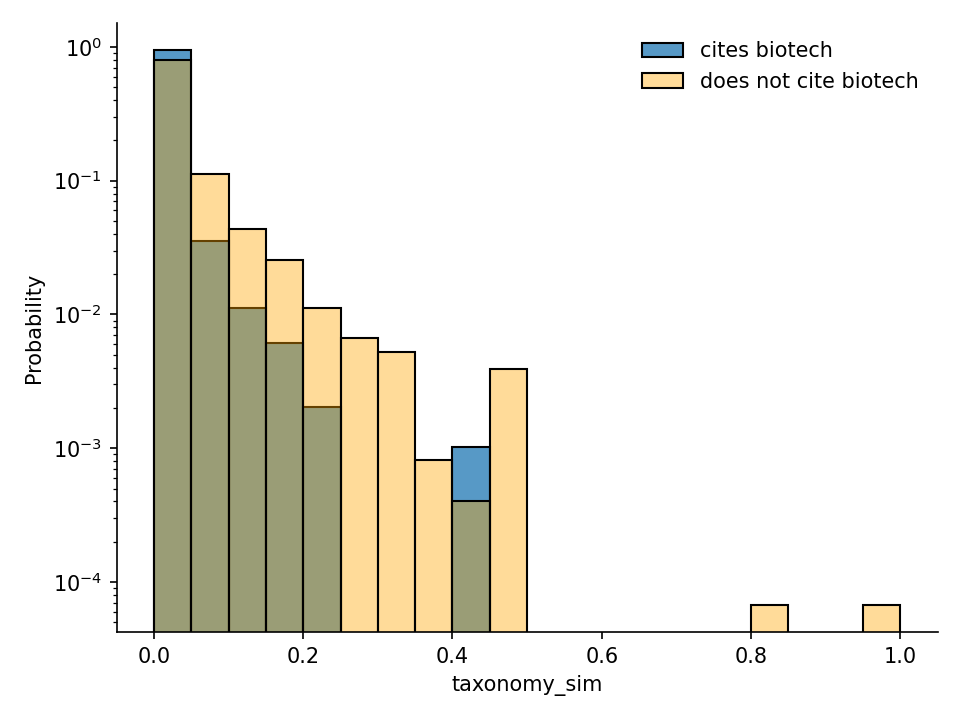

In [855]:
sns.histplot(df_network[df_network.cites_atleast1_biotech].groupby('source').taxonomy_sim.mean(),
             label='cites biotech',
         bins=np.arange(0,1.01,.05), kde=False, stat='probability')

sns.histplot(df_network[~ df_network.cites_atleast1_biotech].groupby('source').taxonomy_sim.mean(),
             label='does not cite biotech',
         bins=np.arange(0,1.01, .05), kde=False, stat='probability', color='orange', alpha=.4)

sns.despine()
plt.yscale('log')
plt.legend(frameon=False)
#plt.xlabel('Mean technological similarity to precursors')
plt.tight_layout()

In [925]:
(df_network[ df_network.cites_atleast1_biotech].groupby('source').jaccard_IPC4.mean() == 1).sum() / 982

0.07535641547861507

In [940]:
temp = df_network.drop_duplicates(subset='source').set_index('source').loc[df_network.source.unique()][['cites_atleast1_biotech']]
temp['jaccard_IPC4'] = df_network.groupby('source').jaccard_IPC4.mean().loc[temp.index]

<IPython.core.display.Javascript object>


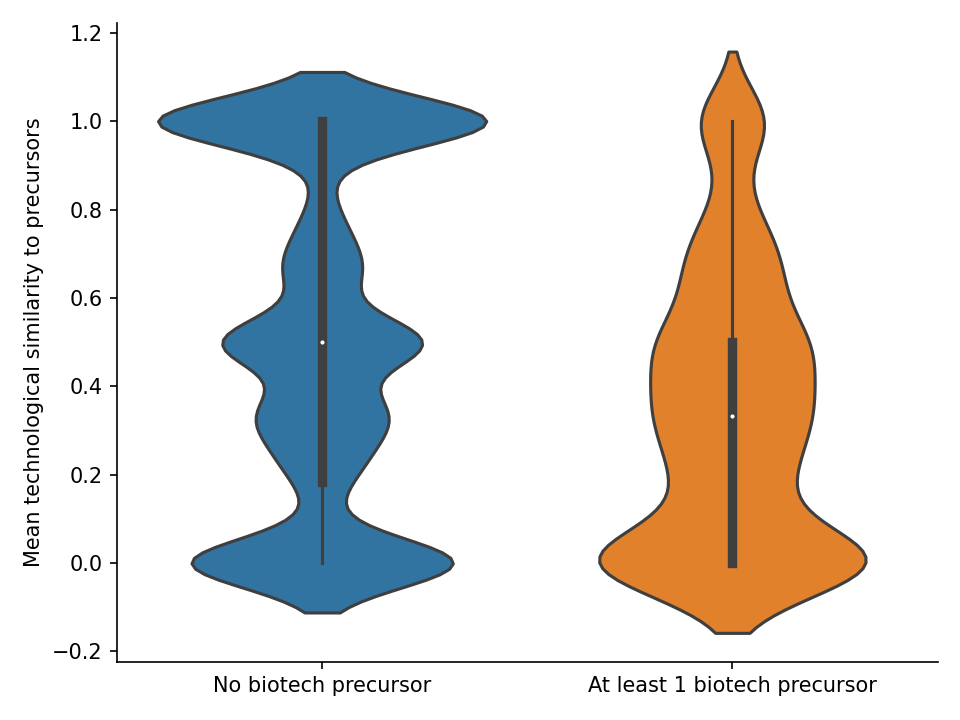

In [948]:
sns.violinplot(data=temp, x='cites_atleast1_biotech', y='jaccard_IPC4')
sns.despine()
plt.ylabel('Mean technological similarity to precursors')
plt.xlabel('')
plt.xticks([0,1], ['No biotech precursor', 'At least 1 biotech precursor'])
plt.tight_layout()

In [961]:
temp = df_network.drop_duplicates(subset='source').set_index('source')[['source_is_biotech']]
temp['jaccard_IPC4'] = df_network.groupby('source').jaccard_IPC4.mean().loc[temp.index]

<IPython.core.display.Javascript object>


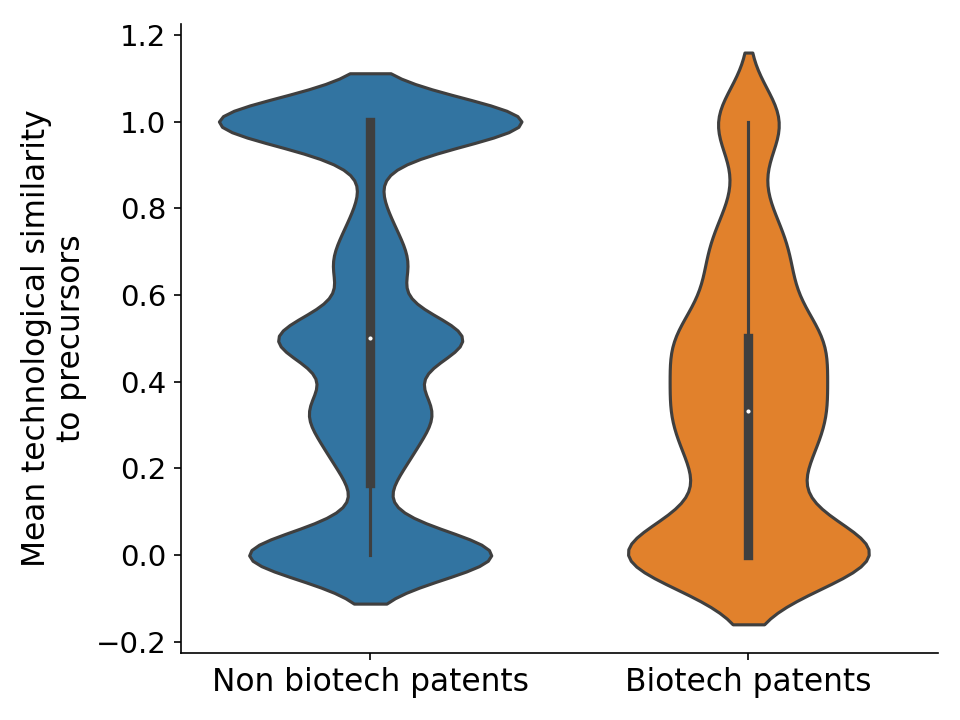

In [1017]:
sns.violinplot(data=temp, x='source_is_biotech', y='jaccard_IPC4')
sns.despine()
plt.ylabel('Mean technological similarity\nto precursors', fontsize=15)
plt.xlabel('')
plt.xticks([0,1], ['Non biotech patents', 'Biotech patents'], fontsize=15)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('tech_similarity.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


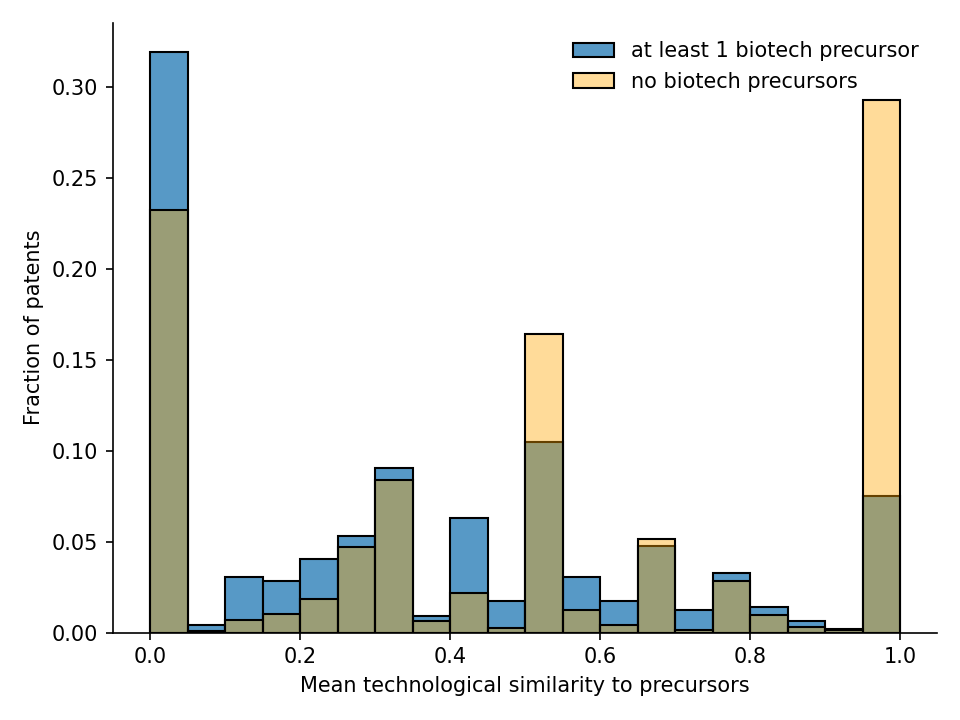

In [916]:
sns.histplot(df_network[df_network.cites_atleast1_biotech].groupby('source').jaccard_IPC4.mean(),
             label='at least 1 biotech precursor',
         bins=np.arange(0,1.01,.05), kde=False, stat='probability')

sns.histplot(df_network[~ df_network.cites_atleast1_biotech].groupby('source').jaccard_IPC4.mean(),
             label='no biotech precursors',
         bins=np.arange(0,1.01, .05), kde=False, stat='probability', color='orange', alpha=.4)

sns.despine()
plt.legend(frameon=False)
plt.xlabel('Mean technological similarity to precursors')
plt.ylabel('Fraction of patents')
plt.tight_layout()

In [ ]:
sns.histplot(df_network[].groupby('source').jaccard_IPC4.mean(), label='all patents',
         bins=np.arange(0,1.01,.05), kde=False, stat='probability')

sns.histplot(df_network[df_network.source_is_biotech].groupby('source').jaccard_IPC4.mean(), label='biotech patents',
         bins=np.arange(0,1.01, .05), kde=False, stat='probability', color='orange', alpha=.4)

sns.despine()
plt.legend(frameon=False)
plt.xlabel('Mean technological similarity to precursors')
plt.tight_layout()

In [864]:
df[df.is_biotech]

,IPC,prio_year,app_year,IPC4,IPC3,is_biotech
EP19780100395,"[A61K038/21, C07K014/555, C12P021/00]",1977.0,1978.0,"[A61K, C07K, C12P]","[A61, C07, C12]",True
EP19780100463,"[A61K038/00, A61P001/12, A61P011/14, A61P023/0...",1977.0,1978.0,"[A61K, A61P, C07K]","[A61, C07]",True
EP19780100717,"[A61K039/00, A61K047/48, C07K001/107, C08G018/...",1977.0,1978.0,"[A61K, C07K, C08G, C08H, C12N, G01N]","[A61, C07, C08, C12, G01]",True
EP19780101447,"[A61K038/00, A61K038/08, A61K038/22, A61P001/1...",1977.0,1978.0,"[A61K, A61P, C07K]","[A61, C07]",True
EP19780101826,"[A61K038/00, A61P031/04, C07F009/38, C07K001/1...",1977.0,1978.0,"[A61K, A61P, C07F, C07K]","[A61, C07]",True
...,...,...,...,...,...,...
EP20180162980,"[C07K014/725, G01N033/50, G01N033/68]",2012.0,2013.0,"[C07K, G01N]","[C07, G01]",True
EP20180188293,[C07K014/765],2009.0,2010.0,[C07K],[C07],True
EP20180193786,"[A61K038/53, C07K014/415, C12N009/00, C12N015/82]",2013.0,2014.0,"[A61K, C07K, C12N]","[A61, C07, C12]",True
EP20180196382,"[A61K038/17, A61P003/04, A61P003/10, A61P005/5...",2010.0,2011.0,"[A61K, A61P]",[A61],True


In [975]:
citing_biotech = df.loc[df_network[df_network.source_is_biotech].source.unique()][['app_year']]
citing_biotech['biotech_share'] = df_network[df_network.source_is_biotech].groupby('source').target_is_biotech.mean()

In [874]:
citing_biotech.to_csv('citing_biotech_francesco.csv')

In [910]:
from scipy.stats import ks_2samp

In [977]:
ks_2samp(citing_biotech[citing_biotech.biotech_share >= .5].app_year.tolist(),
        citing_biotech[citing_biotech.biotech_share < .5].app_year.tolist())

KstestResult(statistic=0.25261291351584636, pvalue=2.949862576429041e-13)

<IPython.core.display.Javascript object>


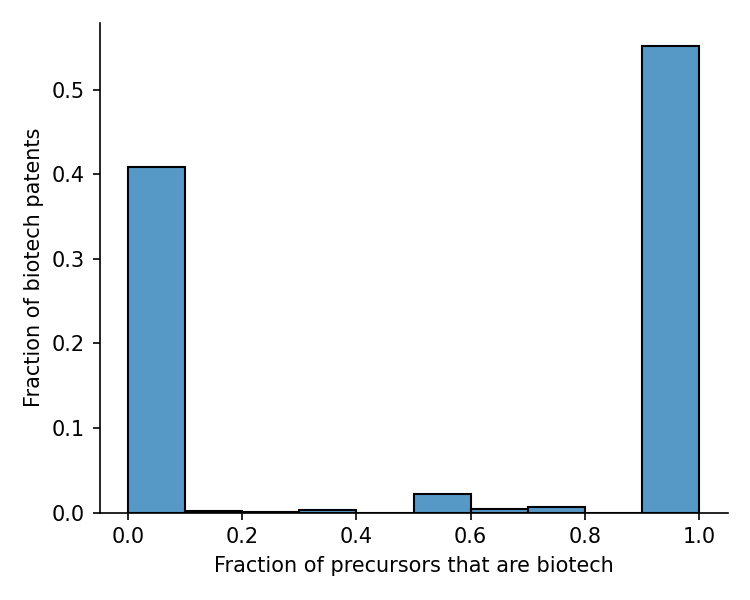

In [985]:
plt.figure(figsize=(5,4))
sns.histplot(citing_biotech.biotech_share, bins=np.arange(0,1.01,.1), stat='proportion')
sns.despine()
plt.ylabel('Fraction of biotech patents')
plt.xlabel('Fraction of precursors that are biotech')

plt.tight_layout()
plt.savefig('dist_fracbiotechprecursors.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


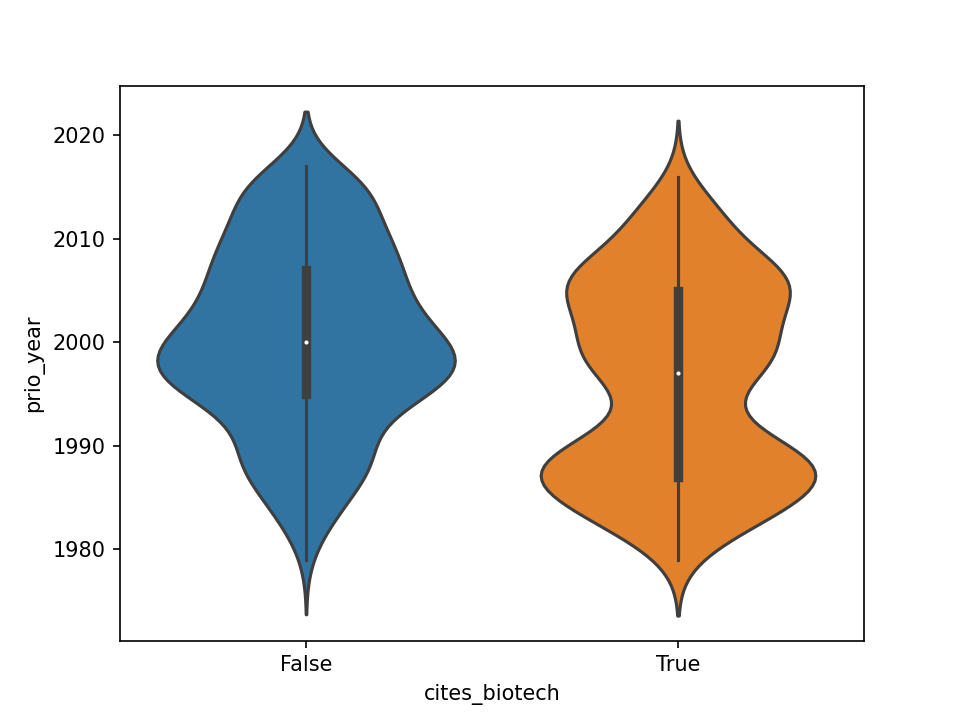

<AxesSubplot:xlabel='cites_biotech', ylabel='prio_year'>

In [974]:
sns.violinplot(data = citing_biotech,
               x = 'cites_biotech',
               y = 'prio_year')

<IPython.core.display.Javascript object>


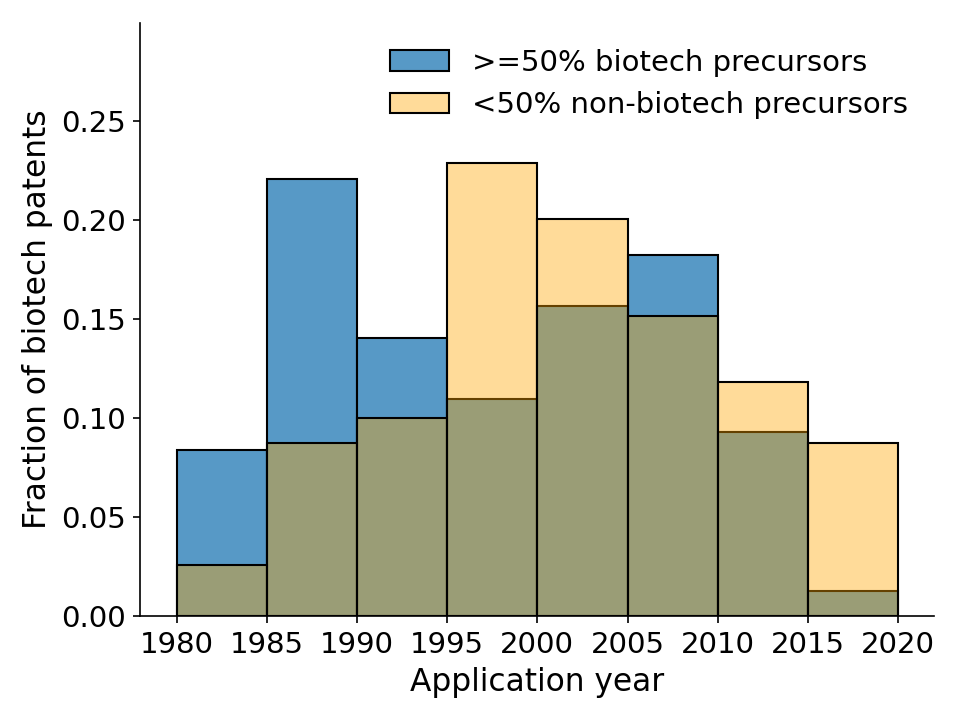

In [1016]:
sns.histplot(citing_biotech[citing_biotech.biotech_share >= .5].app_year, label='>=50% biotech precursors',
            stat='probability', kde=False, bins=np.arange(1980, 2021, 5))
sns.histplot(citing_biotech[citing_biotech.biotech_share < .5].app_year, alpha=.4, label='<50% non-biotech precursors', color='orange',
        stat='probability', kde=False,  bins=np.arange(1980, 2021, 5))
plt.legend(frameon=False, fontsize=14)
plt.ylabel('Fraction of biotech patents', fontsize=15)
plt.xlabel('Application year', fontsize=15)
plt.yticks(np.arange(0, .251, .05), fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(0, .3)
sns.despine()
plt.tight_layout()
plt.savefig('biotech_precursors_time.png', bbox_inches='tight')

In [892]:
pd.Series(sum(citing_biotech[citing_biotech.biotech_share < .1].IPC4.tolist(), [])).value_counts().head(6),\
pd.Series(sum(citing_biotech[citing_biotech.biotech_share >= 1.].IPC4.tolist(), [])).value_counts().head(6)

(A61K    189
 C12N    157
 C07K    149
 A61P    116
 G01N    114
 C12Q     78
 dtype: int64,
 C07K    239
 A61K    235
 C12N    227
 G01N    176
 A61P    164
 C12P    125
 dtype: int64)

In [997]:
df_network.groupby('source').apply(len).value_counts()

1     12847
2      2192
3       475
4       134
5        59
6        17
7        11
8         4
10        3
9         1
12        1
15        1
dtype: int64

<IPython.core.display.Javascript object>


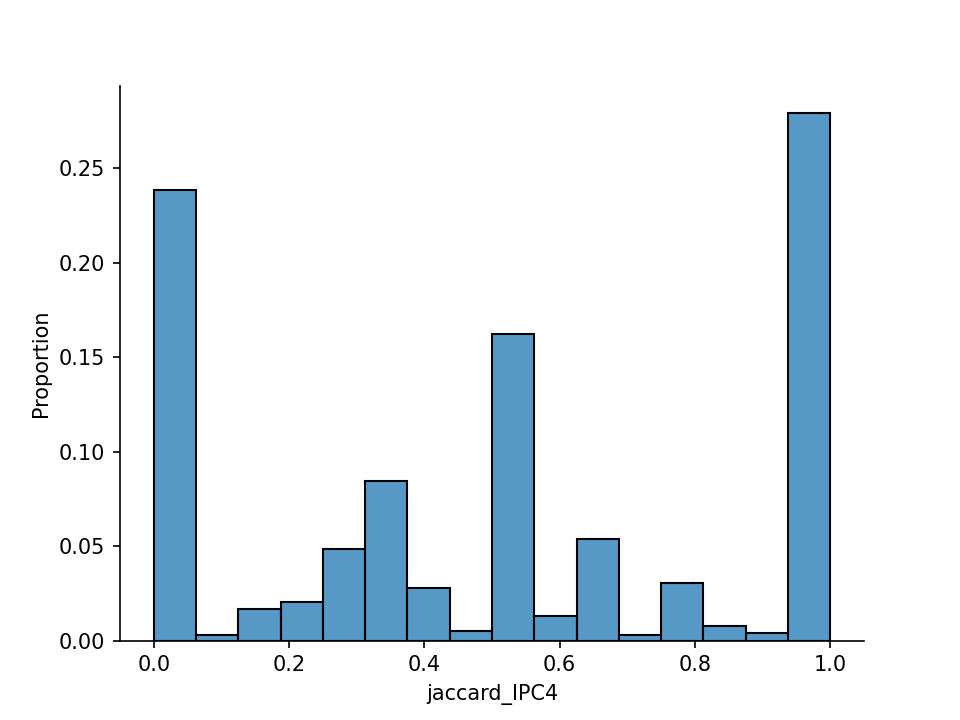

In [989]:
sns.histplot(df_network.groupby('source').jaccard_IPC4.mean(), stat='proportion')
sns.despine()

In [1004]:
df_network[df_network.source_is_biotech].source.unique().shape, df_network[df_network.target_is_biotech].target.unique().shape

((937,), (627,))

In [994]:
df_network.source.unique().shape, df_network.target.unique().shape, len(nodes)

((15745,), (12543,), 25852)

<IPython.core.display.Javascript object>


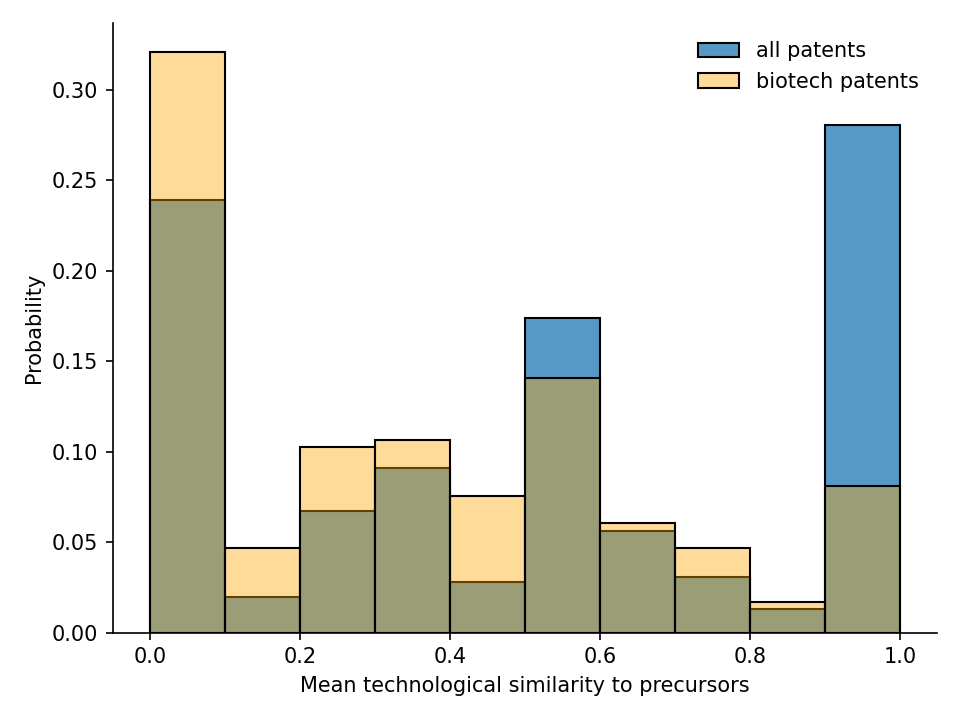

In [913]:
sns.histplot(df_network.groupby('source').jaccard_IPC4.mean(), label='all patents',
         bins=np.arange(0,1.01,.1), kde=False, stat='probability')

sns.histplot(df_network[df_network.source_is_biotech].groupby('source').jaccard_IPC4.mean(), label='biotech patents',
         bins=np.arange(0,1.01, .1), kde=False, stat='probability', color='orange', alpha=.4)

sns.despine()
plt.legend(frameon=False)
plt.xlabel('Mean technological similarity to precursors')
plt.tight_layout()

<IPython.core.display.Javascript object>


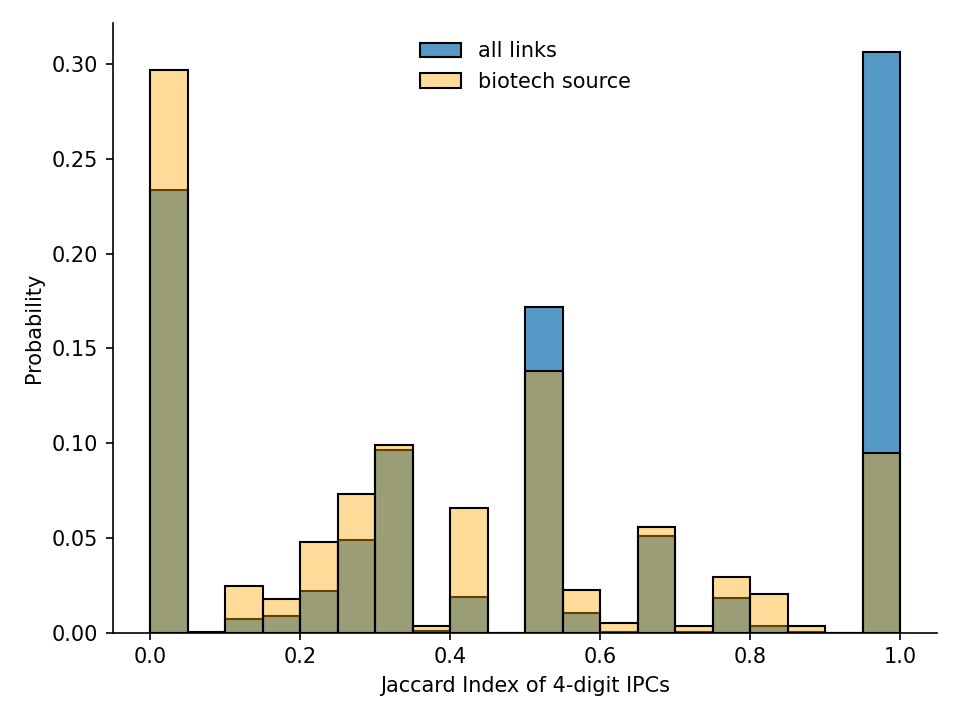

In [625]:
sns.histplot(df_network.jaccard_IPC4, label='all links',
         bins=np.arange(0,1.01,.05), kde=False, stat='probability')

sns.histplot(df_network[df_network.source_is_biotech].jaccard_IPC4, label='biotech source',
         bins=np.arange(0,1.01, .05), kde=False, stat='probability', color='orange', alpha=.4)

sns.despine()
plt.legend(frameon=False)
plt.xlabel('Jaccard Index of 4-digit IPCs')
plt.tight_layout()

### What are the IPC codes cited by biotech patents?

In [754]:
biotech_source_IPC4s = pd.Series(sum(df_network[df_network.source_is_biotech].target_IPC4.tolist(), [])).value_counts()
biotech_source_IPC4s /= biotech_source_IPC4s.sum()

In [752]:
# for every link, IPC4s of the targets
target_IPC4s = pd.Series(sum(df_network.target_IPC4.tolist(), [])).value_counts()
target_IPC4s /= target_IPC4s.sum()

In [843]:
(target_IPC4s.loc[biotech_source_IPC4s.index] / biotech_source_IPC4s).sort_values(ascending=False).head(20)

C10M    19.263139
G02F    16.798187
C10L    16.524304
G01R    14.333236
B60T    14.333236
F02M    13.648527
B23K    13.237702
B41M    12.689935
C04B    12.507346
C10N    12.416051
A01D    11.594401
H02G    11.229223
C23C    10.590162
H02P    10.407573
F16D     9.859806
C09B     9.677217
E04B     9.312039
H05K     8.855566
H04W     8.855566
F16J     8.672977
dtype: float64

Most over-represented (difference):

C11D:  DETERGENT COMPOSITIONS; USE OF SINGLE SUBSTANCES AS DETERGENTS; SOAP OR SOAP-MAKING; RESIN SOAPS; RECOVERY OF GLYCEROL
C07D:  HETEROCYCLIC COMPOUNDS
B65D:  CONTAINERS FOR STORAGE OR TRANSPORT OF ARTICLES OR MATERIALS, e.g. BAGS, BARRELS, BOTTLES, BOXES, CANS, CARTONS, CRATES, DRUMS, JARS, TANKS, HOPPERS, FORWARDING CONTAINERS; ACCESSORIES, CLOSURES, OR FITTINGS THEREFOR; PACKAGING ELEMENTS; PACKAGES
H04N:  PICTORIAL COMMUNICATION

<IPython.core.display.Javascript object>


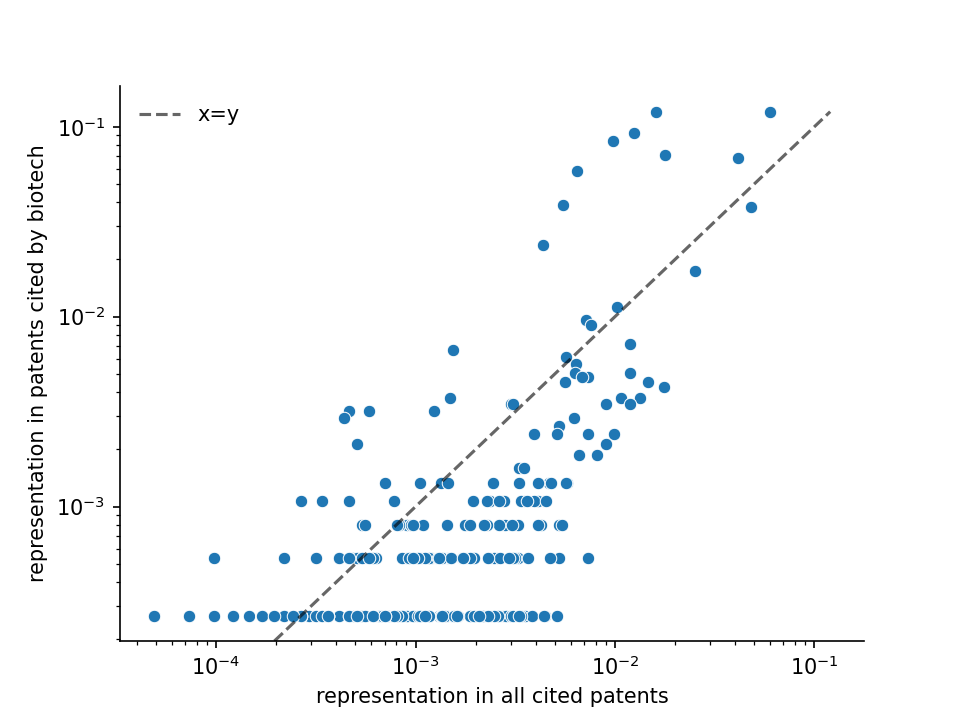

Text(0, 0.5, 'representation in patents cited by biotech')

In [767]:
sns.scatterplot(x = target_IPC4s.loc[biotech_source_IPC4s.index], 
                y = biotech_source_IPC4s)
plt.plot([0,.12], [0,.12], '--', c='black', alpha=.6, label='x=y')
plt.xscale('log')
plt.yscale('log')
sns.despine()
plt.legend(frameon=False)
plt.xlabel('representation in all cited patents')
plt.ylabel('representation in patents cited by biotech')